In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*

In [62]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [63]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [64]:
%matplotlib inline

# Data

In [65]:
# Read data
path = '../../../dataset_sim/mpc_motions_continuous.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(29, 30), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  1714


In [66]:
motion.shape

(1714, 31)

## Height-Force plots

In [67]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [68]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

### Footstep IDXs

In [69]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)
footsteps_clock = get_specific_cmd(motion, 0, 0, -1)
footsteps_count = get_specific_cmd(motion, 0, 0, 1)
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

In [70]:
print(footsteps_count.shape)

(500,)


# Dataset Preparation

In [71]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [72]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [73]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [80]:
def create_com_dataset(dataset, footsteps, motion=None, debug=False):
    inputs = []
    labels = []
    
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            # Compute time difference between
            # current and next footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            if time_difference < 1 and np.any(dataset[footsteps[idx-1], 1:4]) and np.any(dataset[footsteps[idx], 1:4]):
                lf_rh_moving = contacts[footsteps[idx], 0]
                rf_lh_moving = contacts[footsteps[idx], 1]
                
                if lf_rh_moving == rf_lh_moving:
                    print("Invalid")
                    continue
                
                # Compute rotation matrices from odometry orientation
                R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 19:23])
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 19:23])

                # Odom base vectors
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Rotate odometry estimation
                rotated_prev_base = prev_base @ R_prev
                rotated_curr_base = curr_base @ R_prev
                base_displacement = rotated_curr_base - rotated_prev_base
                
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 19:23])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 19:23])
                yaw = curr_yaw - prev_yaw
                
                # Handle angle wrap
                if np.sign(prev_yaw) != np.sign(curr_yaw):
                    print("Angle wrap detected.")
                    continue
                    
                inputs.append(dataset[footsteps[idx-1], 1:31].tolist() +
                              dataset[footsteps[idx], 1:4].tolist() +
                              [lf_rh_moving, rf_lh_moving])
                
                # Labels
                labels.append([base_displacement[0], base_displacement[1], yaw])
                
    return np.array(inputs, dtype=float), np.array(labels, dtype=float)
                
X_motion_fwd_CoM, Y_motion_fwd_CoM = create_com_dataset(motion, footsteps_fwd)
X_motion_clock_CoM, Y_motion_clock_CoM = create_com_dataset(motion, footsteps_clock)
X_motion_count_CoM, Y_motion_count_CoM = create_com_dataset(motion, footsteps_count)
#X_motion_side_left_CoM, Y_motion_side_left_CoM = create_com_dataset(motion, footsteps_side_left)
#X_motion_side_right_CoM, Y_motion_side_right_CoM = create_com_dataset(motion, footsteps_side_right)

# Stack datasets
X_motion_CoM_continuous = np.concatenate((X_motion_fwd_CoM, X_motion_clock_CoM, X_motion_count_CoM))
Y_motion_CoM_continuous = np.concatenate((Y_motion_fwd_CoM, Y_motion_clock_CoM, Y_motion_count_CoM))

print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
Angle wrap detected.
(1623, 35)
(1623, 3)


In [81]:
%store X_motion_CoM_continuous
%store Y_motion_CoM_continuous

Stored 'X_motion_CoM_continuous' (ndarray)
Stored 'Y_motion_CoM_continuous' (ndarray)


# Velocity Check

In [76]:
set(X_motion_CoM_continuous[:, 2])

{-1.0,
 -0.9,
 -0.8,
 -0.7000000000000001,
 -0.6000000000000001,
 -0.5,
 -0.4,
 -0.30000000000000004,
 -0.2,
 -0.1,
 0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0}

# FWD CoM displacements

In [79]:
max(Y_motion_CoM_continuous[:, 0])

0.2634100732030511

In [77]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 1.1, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 0], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 48 samples
Mean CoM(x) displacement of 0.020959139042017533 with a std of 0.004336516865121476
Mean CoM(y) displacement of -6.902868299147448e-05 with a std of 0.0012686007524302884
Mean CoM(yaw) displacement of -9.61168965216857e-05 with a std of 0.0017701543553577594

Velocity 0.2 with 50 samples
Mean CoM(x) displacement of 0.0447919809813589 with a std of 0.0030426355685730815
Mean CoM(y) displacement of -2.949470456810821e-05 with a std of 0.0011084827217992272
Mean CoM(yaw) displacement of 3.685343821929754e-06 with a std of 0.0022011265632494548

Velocity 0.30000000000000004 with 50 samples
Mean CoM(x) displacement of 0.0672670275041273 with a std of 0.004523948079337408
Mean CoM(y) displacement of -6.822613598384084e-05 with a std of 0.0017826086536754033
Mean CoM(yaw) displacement of 4.744468050615458e-05 with a std of 0.002265919803991052

Velocity 0.4 with 43 samples
Mean CoM(x) displacement of 0.0899119909543344 with a std of 0.006662264478861762
Mean CoM(y

# CK CoM displacement

In [22]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 1.1, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 2], -velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 49 samples
Mean CoM(x) displacement of 0.0008179146414641064 with a std of 0.00028775430480251454
Mean CoM(y) displacement of 4.788613204732577e-05 with a std of 0.0033989967637505715
Mean CoM(yaw) displacement of -0.026629632460712985 with a std of 0.002892198048506989

Velocity 0.2 with 43 samples
Mean CoM(x) displacement of 0.0006452632882297399 with a std of 0.0003513339264748651
Mean CoM(y) displacement of 0.00036548470379305087 with a std of 0.0034003574220526143
Mean CoM(yaw) displacement of -0.05216296547434204 with a std of 0.002769338476461463

Velocity 0.30000000000000004 with 35 samples
Mean CoM(x) displacement of 0.0008022337704047755 with a std of 0.0005114643189480277
Mean CoM(y) displacement of 0.0008859550139795015 with a std of 0.0035937065804846325
Mean CoM(yaw) displacement of -0.07802734203752008 with a std of 0.003459078774686862

Velocity 0.4 with 30 samples
Mean CoM(x) displacement of 0.0007885586753809533 with a std of 0.0005250889957629559
Me

# CCK CoM displacement

In [24]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 1.1, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 2], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 38 samples
Mean CoM(x) displacement of 0.000919261817537199 with a std of 0.00034348098444457025
Mean CoM(y) displacement of -0.00027499739708759796 with a std of 0.003415188128267254
Mean CoM(yaw) displacement of 0.02706681605712363 with a std of 0.0027888472457339364

Velocity 0.2 with 41 samples
Mean CoM(x) displacement of 0.001173727964739057 with a std of 0.00040854431636979304
Mean CoM(y) displacement of -0.0006283729074110958 with a std of 0.003494600262170554
Mean CoM(yaw) displacement of 0.05436430974674924 with a std of 0.004064569309866346

Velocity 0.30000000000000004 with 37 samples
Mean CoM(x) displacement of 0.001275569648876369 with a std of 0.00046513353877742156
Mean CoM(y) displacement of -0.0009478764386959646 with a std of 0.003557727369621043
Mean CoM(yaw) displacement of 0.08183864644412187 with a std of 0.004102008227624289

Velocity 0.4 with 40 samples
Mean CoM(x) displacement of 0.0013064340427955776 with a std of 0.0007102736487346469
Mean C

### Fwd Plot

In [25]:
np.arange(0.1, 0.9, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

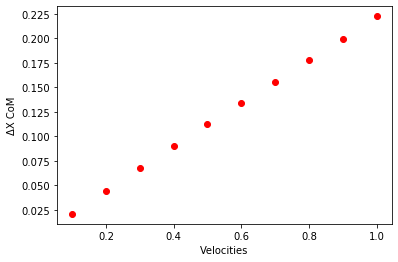

In [26]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394X CoM')
plt.show()

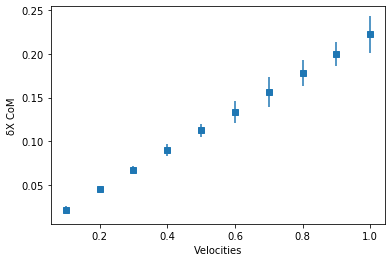

In [27]:
x = np.arange(0.1, 1.1, 0.1)
y = np.array([np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4X CoM')
plt.show()

### Left Plot

In [28]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

NameError: name 'Y_motion_side_left_CoM' is not defined

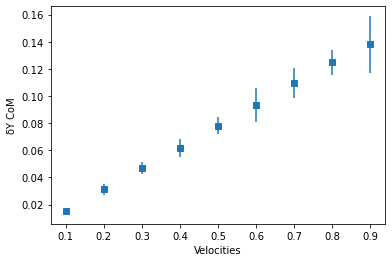

In [19]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = np.array([np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Right Plot

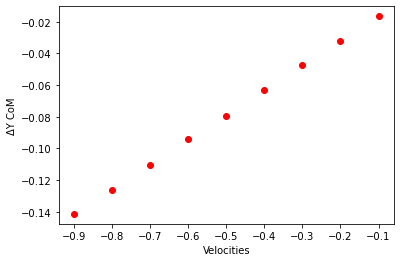

In [31]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9],
         [np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

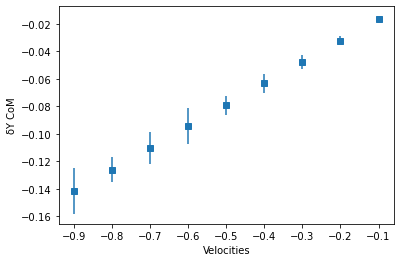

In [32]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
y = np.array([np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Clock Plot

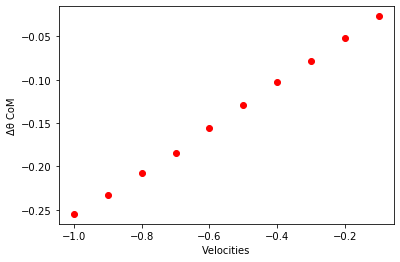

In [31]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0],
         [np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

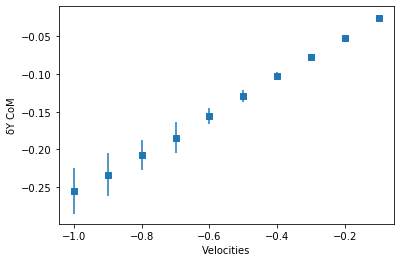

In [32]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0])
y = np.array([np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Count Plot

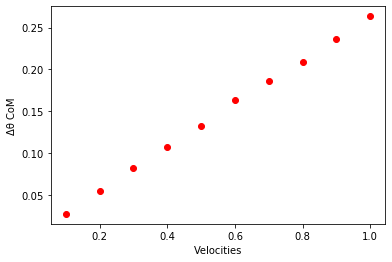

In [33]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

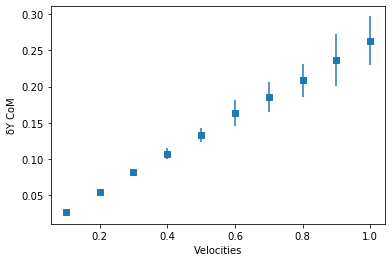

In [34]:
x = np.array(np.arange(0.1, 1.1, 0.1))
y = np.array([np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

## Forwad Check

In [35]:
print(f"Min displacement: {min(Y_motion_fwd_CoM[:, 0])}. Max displacement: {max(Y_motion_fwd_CoM[:, 0])}")

Min displacement: -0.015489258142626028. Max displacement: 0.2634100732030511


## Clockwise Check

In [36]:
print(f"Min displacement: {min(Y_motion_clock_CoM[:, 2])}. Max displacement: {max(Y_motion_clock_CoM[:, 2])}")

Min displacement: -0.3308763499889753. Max displacement: -0.021282279498566536


## Counter Check

In [37]:
print(f"Min displacement: {min(Y_motion_count_CoM[:, 2])}. Max displacement: {max(Y_motion_count_CoM[:, 2])}")

Min displacement: 0.02168094526488501. Max displacement: 0.3552630795877554


## Left Check

In [23]:
print(f"Min displacement: {min(Y_motion_side_left_CoM[:, 1])}. Max displacement: {max(Y_motion_side_left_CoM[:, 1])}")

Min displacement: 0.007853730130729542. Max displacement: 0.09715947318711393


## Right Check

In [24]:
print(f"Min displacement: {min(Y_motion_side_right_CoM[:, 1])}. Max displacement: {max(Y_motion_side_right_CoM[:, 1])}")

Min displacement: -0.0944799924815003. Max displacement: -0.010731300881279493
